<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220523.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표 
* regression
* retention

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, time, date, timezone, timedelta
import os
import plotnine as gg
from plotnine import ggplot, aes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA 
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, mean_squared_error
import sklearn.datasets as skd

# regression

In [9]:
raw = skd.load_boston()
X, y = raw['data'], raw['target']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [11]:
x_tr, x_te, y_tr, y_te = train_test_split(X, y, train_size = .7)

In [23]:
scaler = StandardScaler()
robust = RobustScaler()
x_tr_std = scaler.fit_transform(x_tr)
x_te_std = scaler.transform(x_te)
x_tr_rbt = robust.fit_transform(x_tr)
x_te_rbt = robust.transform(x_te)

In [24]:
fit_rf_std = RandomForestRegressor().fit(x_tr_std, y_tr)
fit_rf_rbt = RandomForestRegressor().fit(x_tr_rbt, y_tr)
fit_rf = RandomForestRegressor().fit(x_tr, y_tr)

In [25]:
pred_rf_std = fit_rf_std.predict(x_te_std)
pred_rf_rbt = fit_rf_std.predict(x_te_rbt)
pred_rf = fit_rf.predict(x_te)

In [27]:
fit_rf.score(x_tr, y_tr),fit_rf_std.score(x_tr_std, y_tr),fit_rf_rbt.score(x_tr_rbt, y_tr), fit_rf.score(x_te, y_te),fit_rf_std.score(x_te_std, y_te),fit_rf_rbt.score(x_te_rbt, y_te)

(0.9818928597108594,
 0.9815606138817579,
 0.984185023308112,
 0.8379492947231155,
 0.8419100786643313,
 0.8282423174225099)

In [53]:
rmse = [mean_squared_error(y_te, pred_rf), mean_squared_error(y_te, pred_rf_std), mean_squared_error(y_te, pred_rf_rbt)]
rmse = np.array(rmse).reshape(-1, 1)
title = np.array(['base', 'standard', 'robust']).reshape(-1,1)
tbl_res = pd.DataFrame(np.c_[title, rmse], columns = ['title', 'rmse'])
tbl_res = tbl_res.assign(rmse = [np.sqrt(float(x)) for x in tbl_res['rmse'].values])
tbl_res

,title,rmse
0,base,3.345963
1,standard,3.304820
2,robust,3.718834


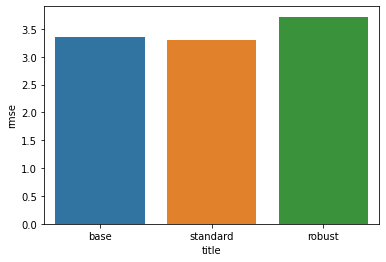

In [54]:
sns.barplot(data = tbl_res, x = 'title', y = 'rmse')

In [70]:
a1 = pd.DataFrame(np.c_[y_te.reshape(-1,1), pred_rf], columns = ['y', 'pred'])
a2 = pd.DataFrame(np.c_[y_te.reshape(-1,1), pred_rf_std], columns = ['y', 'pred'])
a3 = pd.DataFrame(np.c_[y_te.reshape(-1,1), pred_rf_rbt], columns = ['y', 'pred'])

a1.insert(0, 'type', 'base')
a2.insert(0, 'type', 'standard')
a3.insert(0, 'type', 'robust')

In [71]:
tbl_pred = pd.concat([a1, a2, a3], axis = 0)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


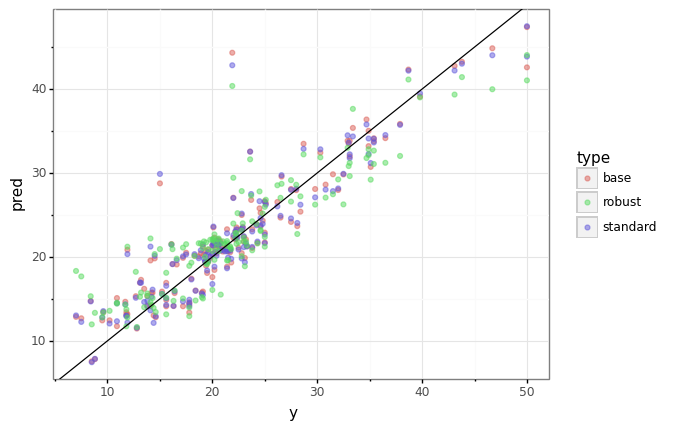

<ggplot: (8730282914057)>

In [74]:
(
    ggplot(tbl_pred, aes('y', 'pred', color = 'type')) +
    gg.geom_point(alpha = .5) +
    gg.geom_abline() +
    gg.theme_bw()
)

# retention

In [76]:
d1 = pd.read_csv('dh_transactions.csv')
d1.head()

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0
3,9999985067,0.85,1,1148,2,1,162016,244,3,1,0
4,9999985131,2.19,1,1323,2,1,89437,244,4,1,0


In [86]:
d2 = d1[['upc', 'day']]
d2.head()

,upc,day
0,7680850106,1
1,3620000470,1
2,1800028064,1
3,9999985067,1
4,9999985131,1


In [87]:
d2 = d2.assign(dt = d2['day'].astype('timedelta64[D]') + datetime.strptime('2021-01-01', '%Y-%m-%d'))
d2.head()

,upc,day,dt
0,7680850106,1,2021-01-02
1,3620000470,1,2021-01-02
2,1800028064,1,2021-01-02
3,9999985067,1,2021-01-02
4,9999985131,1,2021-01-02


In [88]:
d2 = d2.assign(month = d2['dt'].dt.to_period('M'))
d2 = d2[['upc', 'month']]
d2 = d2.sort_values(['upc', 'month'], ascending = True)
d2.head()

,upc,month
522466,111112360,2021-04
767921,111112360,2021-06
820644,111112360,2021-06
865338,111112360,2021-07
889163,111112360,2021-07


In [90]:
list_pu = d2.groupby(['upc', 'month']).head(1)
list_pu.head()

,upc,month
522466,111112360,2021-04
767921,111112360,2021-06
865338,111112360,2021-07
1099392,111112360,2021-08
1956265,111112360,2021-10


In [94]:
list_1st = list_pu.groupby('upc').head(1)

In [158]:
work_month = list_1st['month'].unique()
work_month = sorted(work_month)

In [180]:
for month in work_month : 
  temp_pu = list_1st[list_1st.month == month]
  temp_bill = list_pu[list_pu['upc'].isin(temp_pu['upc'])]
  temp_bill.insert(2, 'var', 1)
  temp = pd.pivot_table(temp_bill, index = 'upc', columns = 'month')
  temp = temp.reset_index()
  temp.columns = [a[1] for a in temp.columns]
  temp.columns = ['upc' if len(str(a)) == 0 else a for a in temp.columns]
  temp = pd.melt(temp, id_vars = 'upc', var_name = 'month')
  temp = temp.assign(value = lambda x : np.where(x['value'].isnull(), 0, x['value']))
  temp = temp.groupby('month')['value'].sum().reset_index()
  temp.insert(0, 'pu_month',  month)
  temp = temp.assign(month = [f'M{int(a):02d}' for a in temp['month'].rank()])

  if month == work_month[0] :
    res = temp
  else :
    res = pd.concat([res, temp], axis = 0)
  
res.tail()

,pu_month,month,value
1,2022-10,M02,1.0
2,2022-10,M03,1.0
0,2022-11,M01,3.0
1,2022-11,M02,1.0
0,2022-12,M01,9.0


In [181]:
pd.pivot_table(res, index = 'pu_month', columns = 'month')

value                                                          \
month       M01    M02    M03    M04    M05    M06    M07    M08    M09   
pu_month                                                                  
2021-01   675.0  620.0  635.0  631.0  625.0  616.0  617.0  613.0  602.0   
2021-02    41.0   21.0   25.0   20.0   18.0   23.0   20.0   19.0   20.0   
2021-03    29.0   14.0   15.0   14.0   17.0   15.0   14.0   14.0   15.0   
2021-04    12.0    4.0    2.0    3.0    3.0    1.0    3.0    2.0    1.0   
2021-05    16.0    5.0    6.0    4.0    4.0    4.0    4.0    6.0    6.0   
2021-06    17.0    9.0    9.0    5.0    8.0    7.0    6.0    6.0    9.0   
2021-07    10.0    4.0    4.0    2.0    2.0    4.0    2.0    3.0    1.0   
2021-08    20.0   12.0   11.0   12.0   11.0   11.0   12.0   13.0   13.0   
2021-09    14.0   10.0   11.0    9.0   10.0   10.0    9.0   10.0    9.0   
2021-10     9.0    8.0    7.0    7.0    7.0    7.0    8.0    7.0    7.0   
2021-11     3.0    2.0    1.0    1.0    1.0    NaN    NaN    NaN    NaN   
2021-12     7.0    3.0    4.0    3.0    3.0    3.0    3.0    3.0    3.0   
2022-01     7.0    3.0    3.0    5.0    3.0    5.0    5.0    4.0    4.0   
2022-02     4.0    3.0    2.0    1.0    1.0    1.0    1.0    NaN    NaN   
2022-03     6.0    4.0    1.0    2.0    1.0    NaN    NaN    NaN    NaN   
2022-04     3.0    1.0    1.0    1.0    1.0    1.0    1.0    NaN    NaN   
2022-05     8.0    5.0    2.0    2.0    1.0    1.0    NaN    NaN    NaN   
2022-06     7.0    3.0    1.0    1.0    NaN    NaN    NaN    NaN    NaN   
2022-07    19.0   15.0   14.0   13.0   13.0   13.0    NaN    NaN    NaN   
2022-08     3.0    3.0    3.0    3.0    3.0    NaN    NaN    NaN    NaN   
2022-09     4.0    3.0    3.0    4.0    NaN    NaN    NaN    NaN    NaN   
2022-10     1.0    1.0    1.0    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11     3.0    1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-12     9.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                 ...                                                          \
month       M10  ...    M15    M16    M17    M18    M19    M20    M21    M22   
pu_month         ...                                                           
2021-01   596.0  ...  569.0  562.0  547.0  553.0  553.0  541.0  533.0  525.0   
2021-02    18.0  ...   19.0   21.0   16.0   18.0   19.0   20.0   17.0   20.0   
2021-03    15.0  ...   12.0   13.0   13.0   15.0   12.0   14.0   13.0   13.0   
2021-04     2.0  ...    2.0    3.0    3.0    4.0    2.0    2.0    1.0    NaN   
2021-05     6.0  ...    6.0    6.0    4.0    7.0    6.0    7.0    NaN    NaN   
2021-06     6.0  ...    7.0    5.0    3.0    8.0    4.0    NaN    NaN    NaN   
2021-07     1.0  ...    3.0    2.0    2.0    1.0    NaN    NaN    NaN    NaN   
2021-08    11.0  ...   12.0   11.0   11.0    NaN    NaN    NaN    NaN    NaN   
2021-09     9.0  ...    9.0    9.0    NaN    NaN    NaN    NaN    NaN    NaN   
2021-10     7.0  ...    7.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2021-11     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2021-12     3.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-01     4.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-02     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-03     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-04     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-05     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-06     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-07     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-08     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-09     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-10     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN  

In [185]:
res.head()

,pu_month,month,value
0,2021-01,M01,675.0
1,2021-01,M02,620.0
2,2021-01,M03,635.0
3,2021-01,M04,631.0
4,2021-01,M05,625.0


In [190]:
res2 = res.assign(ratio = res.groupby('pu_month')['value'].transform(lambda x : x/x.max()))
res2.head()

,pu_month,month,value,ratio
0,2021-01,M01,675.0,1.000000
1,2021-01,M02,620.0,0.918519
2,2021-01,M03,635.0,0.940741
3,2021-01,M04,631.0,0.934815
4,2021-01,M05,625.0,0.925926


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


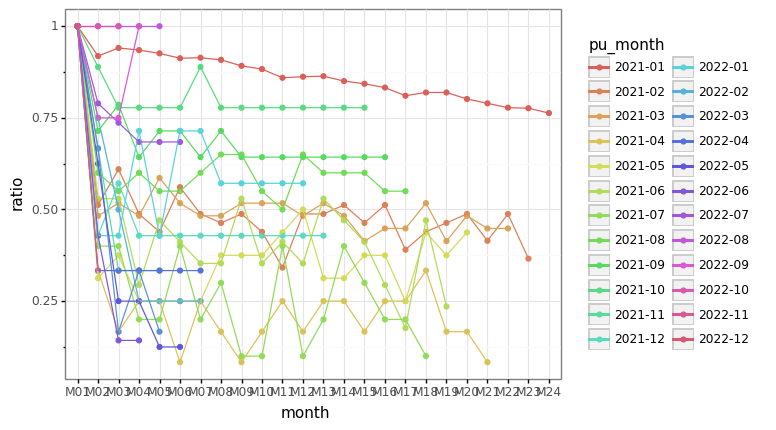

<ggplot: (8730277813393)>

In [194]:
(
    ggplot(res2, aes('month', 'ratio', color = 'pu_month', group = 'pu_month')) +
    gg.geom_point() +
    gg.geom_line() +
    gg.theme_bw() 
)